## RNA-Seq Counts

We have two tables of RNA-Seq read counts now, and we'll have four after we process all of the samples.

We'll read in these count tables using pandas and set up the input for DESeq2.

In [1]:
import pandas as pd

The count tables are tab-delimited text tables.

They have no headers, and we'll want to give meaningful names to the columns. In particular, we'll be constructing a multi-column data frame with one column per sample. In order to make this easier, the name of the counts column should match the name of the sample.

In [5]:
norapa = pd.read_csv("~/Hsf1/RNA-Seq/1M_Hsf1_RNA_0_rapa.counts.txt",
                     delimiter='\t', header=None,
                     names=['gene', 'rapa_0'])
yesrapa = pd.read_csv("~/Hsf1/RNA-Seq/1M_Hsf1_RNA_60_rapa.counts.txt",
                     delimiter='\t', header=None,
                     names=['gene', 'rapa_60'])

Now, we can use the `merge` function to combine the data frames.

We match up rows from different count tables according to the `gene` column.

In [7]:
counts = pd.merge(norapa, yesrapa, on='gene')
counts

,gene,rapa_0,rapa_60
0,Q0010,0,0
1,Q0017,0,0
2,Q0032,0,0
3,Q0045,0,0
4,Q0050,0,0
...,...,...,...
6607,__no_feature,88910,102259
6608,__ambiguous,2264,2534
6609,__too_low_aQual,0,0
6610,__not_aligned,40436,57591


In addition to all the "real" genes, we also have entries in our table that count up the reads that don't match any gene (`__no_feature`), the reads that could match two or more genes (`__ambiguous`, not many of these), and so forth.

We can search for those rows using the `.str.contains()` method on the `.gene` column.

In [9]:
counts[counts.gene.str.contains('__')]

,gene,rapa_0,rapa_60
6607,__no_feature,88910,102259
6608,__ambiguous,2264,2534
6609,__too_low_aQual,0,0
6610,__not_aligned,40436,57591
6611,__alignment_not_unique,141875,109461


We can *remove* all of those unwanted rows from our counts matrix by picking all rows whose gene name does *not* contain a `_` using the `~` operator.

In [11]:
counts = counts[~counts.gene.str.contains('__')]
counts

,gene,rapa_0,rapa_60
0,Q0010,0,0
1,Q0017,0,0
2,Q0032,0,0
3,Q0045,0,0
4,Q0050,0,0
...,...,...,...
6602,YPR201W,3,3
6603,YPR202W,1,2
6604,YPR203W,0,0
6605,YPR204C-A,0,0


Next we'll look at the highest-expression genes using the `.sort_values()` method.

In [12]:
counts.sort_values('rapa_0')

,gene,rapa_0,rapa_60
0,Q0010,0,0
2821,YHR073W-A,0,0
2819,YHR073C-B,0,0
2815,YHR071C-A,0,1
2813,YHR070C-A,0,0
...,...,...,...
2930,YHR174W,7772,5768
6322,YPL220W,7790,4464
2092,YGL008C,9336,9525
4160,YLR110C,13788,19549


### Getting ready for DESeq2

At this point, we'll write a CSV file with the counts matrix in order to look at it in DESeq2.

In [15]:
counts.to_csv("1M.counts.csv", index=False)

We'll also need a "conditions" matrix that describes the samples, for use with DESeq2.

In [14]:
conditions = pd.DataFrame( [{'rapa': 'no'}, {'rapa': 'yes'}],
                          index=['rapa_0', 'rapa_60'])
conditions

,rapa
rapa_0,no
rapa_60,yes


We will write this to a CSV file too.

In [16]:
conditions.to_csv("1M.conditions.csv")

### Manual analysis

Before running DESeq2, let's simply *look* at our data, using matplotlib.

In [17]:
import matplotlib.pyplot as plt

We start by making a scatter plot of the read counts in these two samples.

Because of the very wide spread in gene expression levels, we usually make these plots with log-scaled axes. The `loglog()` function turns on log-scaled axes.

[]

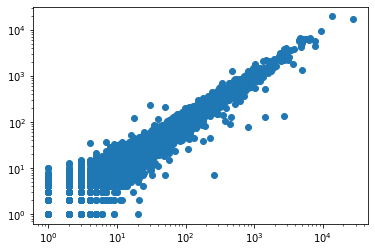

In [19]:
plt.scatter(counts['rapa_0'], counts['rapa_60'])
plt.loglog()

In order to hunt down genes that change a lot between the two conditions, we'll compute the *ratio* between the counts, as a new column.

In [21]:
counts['ratio'] = counts['rapa_60'] / counts['rapa_0']
counts

,gene,rapa_0,rapa_60,ratio
0,Q0010,0,0,NaN
1,Q0017,0,0,NaN
2,Q0032,0,0,NaN
3,Q0045,0,0,NaN
4,Q0050,0,0,NaN
...,...,...,...,...
6602,YPR201W,3,3,1.0
6603,YPR202W,1,2,2.0
6604,YPR203W,0,0,NaN
6605,YPR204C-A,0,0,NaN


We can sort the ratios to look for really extreme values.

In [22]:
counts.sort_values('ratio')

,gene,rapa_0,rapa_60,ratio
4972,YMR245W,1,0,0.0
3943,YKR073C,2,0,0.0
967,YDL172C,3,0,0.0
459,YBR174C,1,0,0.0
5749,YOR068C,1,0,0.0
...,...,...,...,...
6569,YPR170C,0,0,NaN
6570,YPR170W-A,0,0,NaN
6598,YPR197C,0,0,NaN
6604,YPR203W,0,0,NaN


Most of the extreme values show up when the absolute number of reads is very small. These are probably statistical variation and not real biology.

Instead, let's return to sorting genes according to their expression in the unperturbed experiment, taking the 1000 highest-expression genes.

In [23]:
counts.sort_values('rapa_0', ascending=False)

,gene,rapa_0,rapa_60,ratio
2556,YGR192C,27220,17182,0.631227
4160,YLR110C,13788,19549,1.417827
2092,YGL008C,9336,9525,1.020244
6322,YPL220W,7790,4464,0.573042
2930,YHR174W,7772,5768,0.742151
...,...,...,...,...
3706,YKL070W,0,0,NaN
3669,YKL036C,0,1,inf
3662,YKL030W,0,0,NaN
3629,YJR162C,0,0,NaN


The ratio values are all pretty close to 1 here. Maybe there are some high-expression genes with ratio values very different from 1. We really want to see, among all highly-expressed genes, what are the most extreme ratios?

To do this, we can first sort by `rapa_0` expression, take the top 1000, and then sort by value

In [25]:
counts.sort_values('rapa_0', ascending=False).head(1000).sort_values('ratio')

,gene,rapa_0,rapa_60,ratio
6343,YPL240C,256,7,0.027344
4003,YLL024C,2706,136,0.050259
4907,YMR186W,1438,127,0.088317
869,YDL082W,817,79,0.096695
32,YAL005C,231,45,0.194805
...,...,...,...,...
5249,YNL175C,181,334,1.845304
6584,YPR183W,241,454,1.883817
5960,YOR271C,151,297,1.966887
4252,YLR185W,341,703,2.061584


Now we see YAL005C near the top: high expression and a very low `rapa_60` over `rapa_0` ratio.

We can also plot the histogram of these ratios in all highly-expressed genes, using `plt.hist()`

(array([ 10.,  17., 182., 484., 235.,  59.,  10.,   2.,   0.,   1.]),
 array([0.02734375, 0.29845875, 0.56957374, 0.84068874, 1.11180374,
        1.38291874, 1.65403373, 1.92514873, 2.19626373, 2.46737873,
        2.73849372]),
 <BarContainer object of 10 artists>)

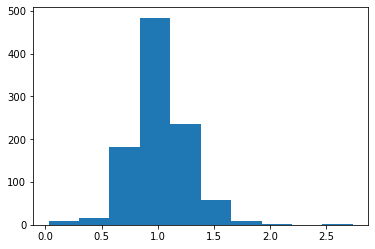

In [27]:
plt.hist(counts.sort_values('rapa_0', ascending=False).head(1000)['ratio'])

We have been sorting according to `rapa_0` expression, but this is asymmetric. We'd miss a gene that was low expression in `rapa_0` and went up a lot in `rapa_60`.

It would be more fair to look at the *average* read count between the two samples.

In [29]:
counts['avg'] = (counts['rapa_0'] + counts['rapa_60'])/2
counts

,gene,rapa_0,rapa_60,ratio,avg
0,Q0010,0,0,NaN,0.0
1,Q0017,0,0,NaN,0.0
2,Q0032,0,0,NaN,0.0
3,Q0045,0,0,NaN,0.0
4,Q0050,0,0,NaN,0.0
...,...,...,...,...,...
6602,YPR201W,3,3,1.0,3.0
6603,YPR202W,1,2,2.0,1.5
6604,YPR203W,0,0,NaN,0.0
6605,YPR204C-A,0,0,NaN,0.0


From here, we can plot the average on the x-axis and the ratio on the y-axis. This is called an "MA" plot.

It has a characteristic arrowhead shape. The big spread on the left-hand side means that the ratios are large when the average is small.

[]

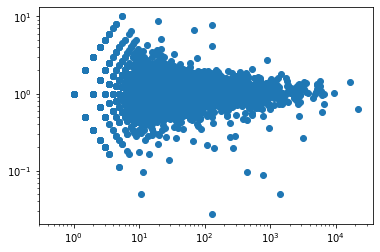

In [30]:
plt.scatter(counts['avg'], counts['ratio'])
plt.loglog()

We will pick an arbitrary cutoff at 100 genes and pick out a "good" data set of genes with average expression over 100.

In [31]:
good = counts[counts['avg'] > 100]
good

,gene,rapa_0,rapa_60,ratio,avg
30,YAL003W,951,767,0.806519,859.0
32,YAL005C,231,45,0.194805,138.0
33,YAL007C,251,219,0.872510,235.0
38,YAL012W,1428,1345,0.941877,1386.5
44,YAL016W,157,154,0.980892,155.5
...,...,...,...,...,...
6567,YPR169W,169,220,1.301775,194.5
6574,YPR173C,141,117,0.829787,129.0
6582,YPR181C,1084,1227,1.131919,1155.5
6584,YPR183W,241,454,1.883817,347.5


Now, we can look at the extreme changes in this data set.

In [32]:
good.sort_values('ratio')

,gene,rapa_0,rapa_60,ratio,avg
6343,YPL240C,256,7,0.027344,131.5
4003,YLL024C,2706,136,0.050259,1421.0
4907,YMR186W,1438,127,0.088317,782.5
869,YDL082W,817,79,0.096695,448.0
32,YAL005C,231,45,0.194805,138.0
...,...,...,...,...,...
1334,YDR276C,99,203,2.050505,151.0
4252,YLR185W,341,703,2.061584,522.0
3050,YIL052C,478,1309,2.738494,893.5
4185,YLR134W,51,209,4.098039,130.0


The systematic gene names aren't very useful to us.

I like to "annotate" these data sets by merging them with a data frame containing the names and brief descriptions of yeast genes.

We'll load this data set from a tab-delimited file.

In [35]:
sgd = pd.read_csv("~/shared/MCB280A_data/S288C_R64-3-1/SGD_features.tab",
            delimiter='\t', header=None)
sgd

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,S000002143,ORF,Dubious,YAL069W,NaN,NaN,chromosome 1,NaN,1,335.0,649.0,W,NaN,1996-07-31,1996-07-31,Dubious open reading frame; unlikely to encode...
1,S000031098,CDS,NaN,NaN,NaN,NaN,YAL069W,NaN,1,335.0,649.0,W,NaN,1996-07-31,1996-07-31,NaN
2,S000028594,ORF,Dubious,YAL068W-A,NaN,NaN,chromosome 1,NaN,1,538.0,792.0,W,NaN,2003-07-29,2003-07-29,Dubious open reading frame; unlikely to encode...
3,S000031372,CDS,NaN,NaN,NaN,NaN,YAL068W-A,NaN,1,538.0,792.0,W,NaN,2003-07-29,2003-07-29,NaN
4,S000121252,ARS,NaN,ARS102,NaN,ARSI-1,chromosome 1,NaN,1,707.0,776.0,NaN,NaN,2014-11-18,2014-11-18|2007-03-07,Autonomously Replicating Sequence
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16449,S000029658,not in systematic sequence of S288C,NaN,MAL61,MAL61,MALT,NaN,L000001021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High-affinity maltose transporter; narrow subs...
16450,S000145155,not in systematic sequence of S288C,NaN,FPG1,FPG1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Putative cell wall mannoprotein involved in fo...
16451,S000133140,not in systematic sequence of S288C,NaN,XDH1,XDH1,NaN,chromosome 15,NaN,15,NaN,NaN,NaN,NaN,NaN,NaN,Xylitol dehydrogenase; involved in utilization...
16452,S000149345,not in systematic sequence of S288C,NaN,IMI1,IMI1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Protein involved in maintaining mitochondrial ...


Now, we'll merge the expression data with the _Saccharomyces_ genome database table. The `sgd` doesn't have column names, so we'll use the number, 3, instead.

In [36]:
annotated_good = pd.merge(good, sgd, left_on = 'gene', right_on=3)
annotated_good

,gene,rapa_0,rapa_60,ratio,avg,0,1,2,3,4,...,6,7,8,9,10,11,12,13,14,15
0,YAL003W,951,767,0.806519,859.0,S000000003,ORF,Verified,YAL003W,EFB1,...,chromosome 1,L000000542,1,142174.0,143160.0,W,NaN,2011-02-03,1996-07-31|1999-07-17,Translation elongation factor 1 beta; stimulat...
1,YAL005C,231,45,0.194805,138.0,S000000004,ORF,Verified,YAL005C,SSA1,...,chromosome 1,L000002069,1,141431.0,139503.0,C,-1.0,2011-02-03,1996-07-31|2007-04-05,ATPase involved in protein folding and NLS-dir...
2,YAL007C,251,219,0.872510,235.0,S000000005,ORF,Verified,YAL007C,ERP2,...,chromosome 1,L000004679,1,138345.0,137698.0,C,NaN,2011-02-03,1996-07-31,Member of the p24 family involved in ER to Gol...
3,YAL012W,1428,1345,0.941877,1386.5,S000000010,ORF,Verified,YAL012W,CYS3,...,chromosome 1,L000000470,1,130799.0,131983.0,W,-16.0,2011-02-03,1996-07-31,Cystathionine gamma-lyase; catalyzes one of th...
4,YAL016W,157,154,0.980892,155.5,S000000014,ORF,Verified,YAL016W,TPD3,...,chromosome 1,L000002325,1,124879.0,126786.0,W,0.5,2011-02-03,1996-07-31,Regulatory subunit A of the heterotrimeric PP2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1212,YPR169W,169,220,1.301775,194.5,S000006373,ORF,Verified,YPR169W,JIP5,...,chromosome 16,NaN,16,878690.0,880168.0,W,NaN,2011-02-03,1996-07-31|2005-12-01,Protein required for biogenesis of the large r...
1213,YPR173C,141,117,0.829787,129.0,S000006377,ORF,Verified,YPR173C,VPS4,...,chromosome 16,L000002956,16,887837.0,886524.0,C,NaN,2011-02-03,1996-07-31,AAA-ATPase involved in multivesicular body (MV...
1214,YPR181C,1084,1227,1.131919,1155.5,S000006385,ORF,Verified,YPR181C,SEC23,...,chromosome 16,L000001846|S000028412,16,899667.0,897361.0,C,NaN,2011-02-03,1996-07-31,"GTPase-activating protein, stimulates the GTPa..."
1215,YPR183W,241,454,1.883817,347.5,S000006387,ORF,Verified,YPR183W,DPM1,...,chromosome 16,L000000524,16,900755.0,901558.0,W,NaN,2011-02-03,1996-07-31,Dolichol phosphate mannose (Dol-P-Man) synthas...


Now we can repeat our analysis: pick genes with average over 100 and sort the extreme ratio values.

In [37]:
annotated_good.sort_values('ratio')

,gene,rapa_0,rapa_60,ratio,avg,0,1,2,3,4,...,6,7,8,9,10,11,12,13,14,15
1175,YPL240C,256,7,0.027344,131.5,S000006161,ORF,Verified,YPL240C,HSP82,...,chromosome 16,L000000822,16,98625.0,96496.0,C,-137.0,1996-07-31,1996-07-31,Hsp90 chaperone; redundant in function with Hs...
739,YLL024C,2706,136,0.050259,1421.0,S000003947,ORF,Verified,YLL024C,SSA2,...,chromosome 12,L000002070,12,97485.0,95566.0,C,NaN,2011-02-03,1996-07-31,HSP70 family ATP-binding protein; involved in ...
906,YMR186W,1438,127,0.088317,782.5,S000004798,ORF,Verified,YMR186W,HSC82,...,chromosome 13,L000000813,13,632355.0,634472.0,W,NaN,2011-02-03,1996-07-31,Cytoplasmic chaperone of the Hsp90 family; pla...
152,YDL082W,817,79,0.096695,448.0,S000002240,ORF,Verified,YDL082W,RPL13A,...,chromosome 4,L000004454,4,308424.0,309388.0,W,NaN,2004-02-11,1996-07-31,Ribosomal 60S subunit protein L13A; not essent...
1,YAL005C,231,45,0.194805,138.0,S000000004,ORF,Verified,YAL005C,SSA1,...,chromosome 1,L000002069,1,141431.0,139503.0,C,-1.0,2011-02-03,1996-07-31|2007-04-05,ATPase involved in protein folding and NLS-dir...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,YDR276C,99,203,2.050505,151.0,S000002684,ORF,Verified,YDR276C,PMP3,...,chromosome 4,NaN,4,1013643.0,1013476.0,C,NaN,2011-02-03,1996-07-31,Small plasma membrane protein; confers resista...
785,YLR185W,341,703,2.061584,522.0,S000004175,ORF,Verified,YLR185W,RPL37A,...,chromosome 12,L000002884,12,522663.0,523288.0,W,NaN,2011-02-03,1996-07-31,Ribosomal 60S subunit protein L37A; required f...
571,YIL052C,478,1309,2.738494,893.5,S000001314,ORF,Verified,YIL052C,RPL34B,...,chromosome 9,L000004466,9,257063.0,256226.0,C,NaN,2011-02-03,1994-12-10,Ribosomal 60S subunit protein L34B; homologous...
778,YLR134W,51,209,4.098039,130.0,S000004124,ORF,Verified,YLR134W,PDC5,...,chromosome 12,L000001356,12,410723.0,412414.0,W,NaN,2011-02-03,1996-07-31,Minor isoform of pyruvate decarboxylase; key e...
